In [1]:
# path to src code
%cd ../../

c:\Users\olarinoyem\Project\Multivate-forecasting


In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
import plotly.io as pio
from itertools import cycle
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
from tqdm.autonotebook import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
import shutil
from src.utils import plotting_utils
from src.dl.dataloaders import TimeSeriesDataModule
from src.dl.multivariate_models import SingleStepRNNConfig, SingleStepRNNModel
import os
import warnings
from plotly.subplots import make_subplots
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from scipy.stats import spearmanr

# Set default plotly template
pio.templates.default = "plotly_white"

# For reproduceability set a random seed
pl.seed_everything(42)
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Ignore warnings
warnings.filterwarnings("ignore")

# Enable progress apply for pandas
tqdm.pandas()

# Set torch float32 matmul precision to high
torch.set_float32_matmul_precision("high")

C:\Users\olarinoyem\AppData\Local\Temp\ipykernel_16940\2598270644.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Seed set to 42


In [3]:
def format_plot(
    fig, legends=None, xlabel="Time", ylabel="Value", title="", font_size=15
):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t: t.update(name=next(names)))
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title_text=title,
        title={"x": 0.5, "xanchor": "center", "yanchor": "top"},
        titlefont={"size": 20},
        legend_title=None,
        legend=dict(
            font=dict(size=font_size),
            orientation="h",
            yanchor="bottom",
            y=0.98,
            xanchor="right",
            x=1,
        ),
        yaxis=dict(
            title_text=ylabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
        xaxis=dict(
            title_text=xlabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
    )
    return fig


def mase(actual, predicted, insample_actual):
    mae_insample = np.mean(np.abs(np.diff(insample_actual)))
    mae_outsample = np.mean(np.abs(actual - predicted))
    return mae_outsample / mae_insample


def forecast_bias(actual, predicted):
    return np.mean(predicted - actual)


def plot_forecast(
    pred_df, forecast_columns, forecast_display_names=None, save_path=None
):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns) == len(forecast_display_names)

    mask = ~pred_df[forecast_columns[0]].isnull()
    colors = px.colors.qualitative.Set2  # Using a different color palette
    act_color = colors[0]
    colors = cycle(colors[1:])

    fig = go.Figure()

    # Actual data plot
    fig.add_trace(
        go.Scatter(
            x=pred_df[mask].index,
            y=pred_df[mask].covidOccupiedMVBeds,
            mode="lines",
            marker=dict(size=6, opacity=0.5),
            line=dict(color=act_color, width=2),
            name="Actual COVID-19 MVBeds trends",
        )
    )

    # Predicted data plot
    for col, display_col in zip(forecast_columns, forecast_display_names):
        fig.add_trace(
            go.Scatter(
                x=pred_df[mask].index,
                y=pred_df.loc[mask, col],
                mode="lines+markers",
                marker=dict(size=4),
                line=dict(color=next(colors), width=2),
                name=display_col,
            )
        )

    return fig


def highlight_abs_min(s, props=""):
    return np.where(s == np.nanmin(np.abs(s.values)), props, "")

In [4]:
if not os.path.exists("../images"):
    os.mkdir("../images")

In [5]:
data = pd.read_csv("data/processed/merged_nhs_covid_data.csv").drop("Unnamed: 0", axis=1).reset_index(drop=True)
data.head()

,areaCode,areaName,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,latitude,longitude,epi_week
0,E40000007,East of England,2022-09-12,9.0,84162,418.0,47,505.0,2.0,2177579.0,19129.0,6235410,52.24,0.41,202237
1,E40000007,East of England,2022-09-11,8.0,84115,421.0,46,429.0,3.0,2177074.0,19127.0,6235410,52.24,0.41,202237
2,E40000007,East of England,2022-09-10,8.0,84069,419.0,34,296.0,0.0,2176645.0,19124.0,6235410,52.24,0.41,202236
3,E40000007,East of England,2022-09-09,9.0,84035,411.0,34,308.0,2.0,2176349.0,19124.0,6235410,52.24,0.41,202236
4,E40000007,East of England,2022-09-08,9.0,84001,421.0,51,335.0,3.0,2176041.0,19122.0,6235410,52.24,0.41,202236


In [6]:
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8054 entries, 0 to 8053
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   areaCode              8054 non-null   object        
 1   areaName              8054 non-null   object        
 2   date                  8054 non-null   datetime64[ns]
 3   covidOccupiedMVBeds   8054 non-null   float64       
 4   cumAdmissions         8054 non-null   int64         
 5   hospitalCases         8054 non-null   float64       
 6   newAdmissions         8054 non-null   int64         
 7   new_confirmed         8054 non-null   float64       
 8   new_deceased          8054 non-null   float64       
 9   cumulative_confirmed  8054 non-null   float64       
 10  cumulative_deceased   8054 non-null   float64       
 11  population            8054 non-null   int64         
 12  latitude              8054 non-null   float64       
 13  longitude         

In [7]:
data.columns

Index(['areaCode', 'areaName', 'date', 'covidOccupiedMVBeds', 'cumAdmissions',
       'hospitalCases', 'newAdmissions', 'new_confirmed', 'new_deceased',
       'cumulative_confirmed', 'cumulative_deceased', 'population', 'latitude',
       'longitude', 'epi_week'],
      dtype='object')

In [8]:
# check the unique values in the areaName column
data['areaName'].unique()

array(['East of England', 'London', 'Midlands',
       'North East and Yorkshire', 'North West', 'South East',
       'South West'], dtype=object)

In [9]:
# Filter data between the specified dates
data_filtered = data[(data["date"] >= "2020-01-01") & (data["date"] < "2021-12-31")]

# Metrics to plot
metrics = [
    "covidOccupiedMVBeds",
    "hospitalCases",
    "newAdmissions",
    "new_confirmed",
    "new_deceased",
]

# Create a subplot for each metric
fig = make_subplots(
    rows=len(metrics),
    cols=1,
    shared_xaxes=True,
    # subplot_titles=[metric.replace("_", " ").title() for metric in metrics],
)

# Plot data for each region and each metric
for i, metric in enumerate(metrics):
    for j, (region, group) in enumerate(data_filtered.groupby("areaName")):
        show_legend = i == 0  # Only show legend for the first metric
        fig.add_trace(
            go.Scatter(
                x=group["date"],
                y=group[metric],
                mode="lines",
                name=region,
                showlegend=show_legend,
            ),
            row=i + 1,
            col=1,
        )

# Update layout
fig.update_layout(
    height=1200,
    width=1000,
    title_text="COVID-19 Data Visualization by Region",
    template="plotly_white",
    legend=dict(y=1, x=1.5, yanchor="top", xanchor="right", orientation="h"),
)

# Update x-axis and y-axis labels
fig.update_xaxes(title_text="Date", row=len(metrics), col=1)
for i, metric in enumerate(metrics):
    fig.update_yaxes(title_text=metric.replace("_", " ").title(), row=i + 1, col=1)

# Show the figure
fig.show()

In [10]:
# flip the data, so it will start from the first date for each region
data_filtered = data_filtered.sort_values(by=["date", "areaName"]).reset_index(drop=True)
data_filtered.head()

,areaCode,areaName,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,latitude,longitude,epi_week
0,E40000007,East of England,2020-04-01,0.0,1400,833.0,167,334.0,75.0,2938.0,455.0,6235410,52.24,0.410000,202014
1,E40000003,London,2020-04-01,0.0,7651,4219.0,767,977.0,189.0,11086.0,1566.0,8982256,51.50,-0.083333,202014
2,E40000008,Midlands,2020-04-01,0.0,5104,2192.0,776,301.0,44.0,2294.0,259.0,4811065,52.98,-0.750000,202014
3,E40000008,Midlands,2020-04-01,0.0,5104,2192.0,776,411.0,108.0,4234.0,721.0,5907872,52.47,-2.290000,202014
4,E40000009,North East and Yorkshire,2020-04-01,0.0,2765,1293.0,507,307.0,32.0,1478.0,152.0,2656980,55.00,-1.866667,202014


In [11]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5751 entries, 0 to 5750
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   areaCode              5751 non-null   object        
 1   areaName              5751 non-null   object        
 2   date                  5751 non-null   datetime64[ns]
 3   covidOccupiedMVBeds   5751 non-null   float64       
 4   cumAdmissions         5751 non-null   int64         
 5   hospitalCases         5751 non-null   float64       
 6   newAdmissions         5751 non-null   int64         
 7   new_confirmed         5751 non-null   float64       
 8   new_deceased          5751 non-null   float64       
 9   cumulative_confirmed  5751 non-null   float64       
 10  cumulative_deceased   5751 non-null   float64       
 11  population            5751 non-null   int64         
 12  latitude              5751 non-null   float64       
 13  longitude         

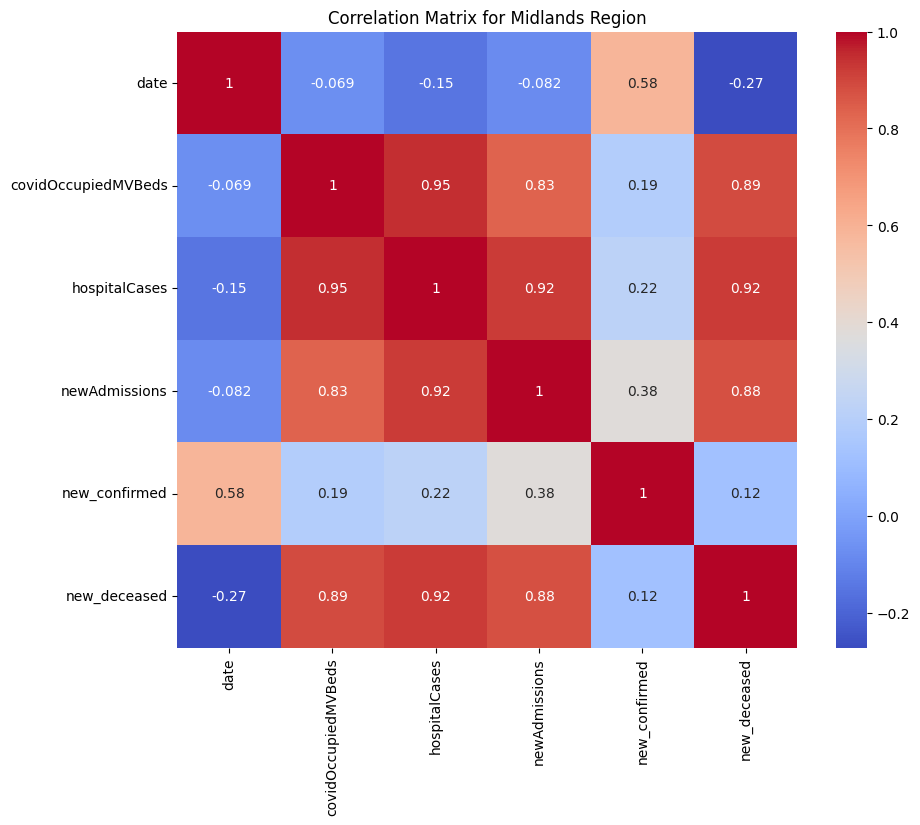

In [12]:
# select midlands region data and do a correlation analysis
midlands_data = data_filtered[data_filtered["areaName"] == "Midlands"]
midlands_data.drop(["areaName", "areaCode", "cumAdmissions","cumulative_confirmed", "cumulative_deceased", "population", "latitude", "longitude", "epi_week"], axis=1, inplace=True)
# Calculate the correlation matrix
correlation_matrix = midlands_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix for Midlands Region")
# plt.savefig("../images/correlation_matrix.png")
plt.show()

- Lockdown 1 (march23, 2020 - july 4, 2020)
- lockdown 2 (Novmeber 5, 2020 - December 2, 2020)
- lockdown 3 (january 6, 2020 - aril12, 2020)


In [13]:
# # Lockdown dates for COVID-19 in the UK
# # Note: These dates are general approximations as specific dates might vary slightly

# # The data starts from early 2020, so we'll consider major lockdown periods in the UK since then

# lockdown_dates = {
#     'Lockdown 1': {'start': '2020-03-23', 'end': '2020-07-04'},
#     'Lockdown 2': {'start': '2020-11-05', 'end': '2020-12-02'},
#     'Lockdown 3': {'start': '2021-01-06', 'end': '2021-04-12'}
# }

# # Converting dates to datetime for plotting
# for lockdown in lockdown_dates:
#     lockdown_dates[lockdown]['start'] = pd.to_datetime(lockdown_dates[lockdown]['start'])
#     lockdown_dates[lockdown]['end'] = pd.to_datetime(lockdown_dates[lockdown]['end'])

# # Plotting the trend component with lockdown periods
# plt.figure(figsize=(14, 6))
# plt.plot(trend_hospital_cases, label='Trend of Hospital Cases', color='blue')

# # Adding shaded areas for lockdown periods
# for lockdown in lockdown_dates:
#     plt.axvspan(lockdown_dates[lockdown]['start'], lockdown_dates[lockdown]['end'], color='red', alpha=0.3, label=lockdown)

# plt.xlabel('Date')
# plt.ylabel('Hospital Cases')
# plt.title('Trend of Hospital Cases with Lockdown Periods')
# plt.legend()
# plt.show()


In [14]:
# # Re-loading the data due to code execution state reset
# england_data = pd.read_csv(file_path)
# england_data['date'] = pd.to_datetime(england_data['date'])
# england_data_time_series = england_data.set_index('date')

# # Handling missing values using interpolation
# england_data_time_series_interpolated = england_data_time_series.interpolate()

# # Re-performing seasonal decomposition on 'Hospital Cases' after handling missing values
# decomposition_hospital_cases = seasonal_decompose(england_data_time_series_interpolated['Hospital Cases'], model='additive')

# # Extracting the seasonal and trend components
# seasonal_hospital_cases = decomposition_hospital_cases.seasonal
# trend_hospital_cases = decomposition_hospital_cases.trend

# # Plotting the trend and seasonal components
# plt.figure(figsize=(14, 8))

# plt.subplot(2, 1, 1)
# plt.plot(trend_hospital_cases, label='Trend of Hospital Cases', color='blue')
# plt.title('Trend Component in Hospital Cases')
# plt.legend()

# plt.subplot(2, 1, 2)
# plt.plot(seasonal_hospital_cases, label='Seasonal Variation in Hospital Cases', color='green')
# plt.title('Seasonal Component in Hospital Cases')
# plt.legend()

# plt.tight_layout()
# plt.show()


In [15]:
# # Time-lagged correlation analysis for ICU beds and the features in the Midlands region
# # Select the features to include in the analysis
# features = [
#     "covidOccupiedMVBeds",
#     "hospitalCases",
#     "newAdmissions",
#     "new_confirmed",
#     "new_deceased",
# ]

# # Define the maximum lag period
# max_lag = 30

# # Calculate the time-lagged correlation for each feature
# time_lagged_correlation = {}
# for feature in features:
#     time_lagged_correlation[feature] = []
#     for lag in range(max_lag):
#         correlation = midlands_data[feature].corr(midlands_data[feature].shift(lag))
#         time_lagged_correlation[feature].append(correlation)
        
# # Plot the time-lagged correlation for each feature
# plt.figure(figsize=(14, 8))
# for feature in features:
#     plt.plot(time_lagged_correlation[feature], label=feature)
    
# plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
# plt.xlabel('Time Lag (Days)')
# plt.ylabel('Correlation')
# plt.title('Time-Lagged Correlation for Features in Midlands Region')
# plt.legend()
# plt.show()

In [16]:
# Function to calculate the optimal lag for each variable
def optimal_lag(target, features, max_lag):
    optimal_lags = {}
    for feature in features:
        min_error = float('inf')
        best_lag = 0

        for lag in range(1, max_lag + 1):
            # Creating the lagged feature
            temp_df = data.copy()
            temp_df[feature + '_lag'] = temp_df[feature].shift(lag)

            # Dropping missing values (introduced by shifting)
            temp_df = temp_df.dropna()

            # Splitting the dataset
            X = temp_df[[feature + '_lag']]
            y = temp_df[target]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

            # Training the model
            model = LinearRegression()
            model.fit(X_train, y_train)

            # Predicting and calculating the error
            predictions = model.predict(X_test)
            error = mae(y_test, predictions)

            # Checking if this lag results in a lower error
            if error < min_error:
                min_error = error
                best_lag = lag

        optimal_lags[feature] = best_lag

    return optimal_lags

# Defining the target variable and features
target = 'covidOccupiedMVBeds'
features = [
    "hospitalCases",
    "newAdmissions",
    "new_confirmed",
    "new_deceased",
]

# Calculating the optimal lag for each feature
optimal_lags = optimal_lag(target, features, max_lag=30)
optimal_lags



{'hospitalCases': 2, 'newAdmissions': 1, 'new_confirmed': 5, 'new_deceased': 1}

In [17]:
# Define a function to calculate the optimal lag for each variable using Spearman correlation
def optimal_lag_spearman_ml(data, target, features, max_lag, model):
    optimal_lags = {}
    
    # TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    for feature in features:
        best_spearman_corr = 0
        best_lag = 0

        for lag in range(1, max_lag + 1):
            # Create a lagged feature
            temp_data = data.copy()
            temp_data[feature + '_lag'] = temp_data[feature].shift(lag)
            temp_data.dropna(inplace=True)

            # Cross-validation
            spearman_corrs = []
            for train_index, test_index in tscv.split(temp_data):
                train, test = temp_data.iloc[train_index], temp_data.iloc[test_index]
                
                # Spearman correlation
                corr, _ = spearmanr(train[target], train[feature + '_lag'])
                spearman_corrs.append(corr)

            avg_spearman_corr = np.mean(spearman_corrs)
            if avg_spearman_corr > best_spearman_corr:
                best_spearman_corr = avg_spearman_corr
                best_lag = lag

        optimal_lags[feature] = best_lag

    return optimal_lags

# Define the target variable and features
target = 'covidOccupiedMVBeds'
features = [
    "hospitalCases",
    "newAdmissions",
    "new_confirmed",
    "new_deceased",
]
max_lag_days = 30  # Maximum lag in days to consider

# Find the optimal lag for each feature
optimal_lags = optimal_lag_spearman_ml(midlands_data, target, features, max_lag_days, LinearRegression())

optimal_lags



{'hospitalCases': 2,
 'newAdmissions': 14,
 'new_confirmed': 30,
 'new_deceased': 2}

In [18]:
class LogTime:
    def __enter__(self):
        self.start = pd.Timestamp.now()

    def __exit__(self, *args):
        print(f"Duration: {pd.Timestamp.now() - self.start}")

def add_rolling_features(df, window_size, columns, agg_funcs=None):
    if agg_funcs is None:
        agg_funcs = ['mean']
    added_features = {}
    for column in columns:
        for func in agg_funcs:
            roll_col_name = f"{column}_rolling_{window_size}_{func}"
            df[roll_col_name] = df[column].rolling(window_size).agg(func)
            if column not in added_features:
                added_features[column] = []
            added_features[column].append(roll_col_name)
    # Drop rows with NaN values which are the result of rolling window
    df.dropna(inplace=True)
    return df, added_features

# Configuration
window_size = 7
columns_to_roll = ["hospitalCases", "newAdmissions", "new_confirmed", "new_deceased"]
agg_funcs = ['mean']

# Apply rolling features for each column
final_data, added_features = add_rolling_features(midlands_data, window_size, columns_to_roll, agg_funcs)

# Print added features for each column
for column, features in added_features.items():
    print(f"{column}: {', '.join(features)}")
# Assuming 'final_data' is your initial DataFrame containing the required information.

# Define the target variable and features



hospitalCases: hospitalCases_rolling_7_mean
newAdmissions: newAdmissions_rolling_7_mean
new_confirmed: new_confirmed_rolling_7_mean
new_deceased: new_deceased_rolling_7_mean


In [19]:
midlands_data.head()

,date,covidOccupiedMVBeds,hospitalCases,newAdmissions,new_confirmed,new_deceased,hospitalCases_rolling_7_mean,newAdmissions_rolling_7_mean,new_confirmed_rolling_7_mean,new_deceased_rolling_7_mean
29,2020-04-04,360.0,2925.0,559,190.0,53.0,2339.285714,596.714286,312.857143,72.571429
30,2020-04-04,360.0,2925.0,559,347.0,107.0,2444.000000,565.714286,319.428571,81.571429
38,2020-04-05,406.0,3091.0,489,148.0,60.0,2572.428571,524.714286,281.857143,74.714286
39,2020-04-05,406.0,3091.0,489,290.0,117.0,2749.571429,511.428571,292.857143,84.857143
47,2020-04-06,419.0,3250.0,439,219.0,68.0,2949.428571,491.000000,260.000000,77.571429


In [20]:
# # create rolling mean statistics for covidOccupiedMVBeds in the Midlands region dataframe using window size of 7 days, 14 and 30 days
# # midlands_data['covidOccupiedMVBeds_7day_mean'] = midlands_data['covidOccupiedMVBeds'].rolling(window=7).mean()
# # midlands_data['covidOccupiedMVBeds_14day_mean'] = midlands_data['covidOccupiedMVBeds'].rolling(window=14).mean()
# # midlands_data['covidOccupiedMVBeds_30day_mean'] = midlands_data['covidOccupiedMVBeds'].rolling(window=30).mean()

# # Plotting the rolling mean statistics using plotly on a single plot
# fig = go.Figure()

# # Plotting the actual data
# fig.add_trace(go.Scatter(x=midlands_data['date'], y=midlands_data['covidOccupiedMVBeds'], mode='lines', name='Actual Data'))

# # Plotting the rolling mean statistics
# fig.add_trace(go.Scatter(x=midlands_data['date'], y=midlands_data['covidOccupiedMVBeds_7day_mean'], mode='lines', name='7-Day Rolling Mean'))
# # fig.add_trace(go.Scatter(x=midlands_data['date'], y=midlands_data['covidOccupiedMVBeds_14day_mean'], mode='lines', name='14-Day Rolling Mean'))
# # fig.add_trace(go.Scatter(x=midlands_data['date'], y=midlands_data['covidOccupiedMVBeds_30day_mean'], mode='lines', name='30-Day Rolling Mean'))

# # Updating the layout
# fig.update_layout(
#     title='Rolling Mean Statistics for COVID-19 Occupied MV Beds in Midlands Region',
#     xaxis_title='Date',
#     yaxis_title='COVID-19 Occupied MV Beds',
#     template='plotly_white'
# )

# # Showing the plot
# fig.show()


In [21]:
class LogTime():
    from time import time
    
    def __enter__(self):
        self.start_time = self.time()
        print("Starting operation...")
        
    def __exit__(self, type, value, traceback):
        elapsed_time = self.time() - self.start_time
        print(f"Operation completed in {elapsed_time} seconds.")

# Define a function to add time-lagged features to the dataset
def add_lags(data, lags, features):
    added_features = []
    for feature in features:
        for lag in lags:
            new_feature = feature + f'_lag_{lag}'
            data[new_feature] = data[feature].shift(lag)
            added_features.append(new_feature)
    return data, added_features


lags = [1, 2, 3, 5, 7, 14, 21]

midlands_data, added_features = add_lags(midlands_data, lags, ['covidOccupiedMVBeds', 'hospitalCases', 'newAdmissions', 'new_deceased'])
midlands_data.dropna(inplace=True)

In [22]:
def create_temporal_features(df, date_column):
    df["month"] = df[date_column].dt.month
    df["day"] = df[date_column].dt.day
    df["day_of_week"] = df[date_column].dt.dayofweek
    return df


midlands_data = create_temporal_features(midlands_data, "date")

In [23]:
midlands_data['date'] = pd.to_datetime(midlands_data['date'])
midlands_data = midlands_data.set_index('date')
midlands_data.head()

,covidOccupiedMVBeds,hospitalCases,newAdmissions,new_confirmed,new_deceased,hospitalCases_rolling_7_mean,newAdmissions_rolling_7_mean,new_confirmed_rolling_7_mean,new_deceased_rolling_7_mean,covidOccupiedMVBeds_lag_1,...,new_deceased_lag_1,new_deceased_lag_2,new_deceased_lag_3,new_deceased_lag_5,new_deceased_lag_7,new_deceased_lag_14,new_deceased_lag_21,month,day,day_of_week
date,,,,,,,,,,,,,,,,,,,,,
2020-04-14,467.0,3345.0,359,330.0,82.0,3368.285714,332.142857,245.000000,80.285714,467.0,...,61.0,96.0,49.0,57.0,63.0,99.0,53.0,4,14,1
2020-04-15,472.0,3101.0,242,216.0,67.0,3326.142857,318.857143,239.571429,74.142857,467.0,...,82.0,61.0,96.0,107.0,110.0,67.0,107.0,4,15,2
2020-04-15,472.0,3101.0,242,394.0,108.0,3279.142857,310.142857,265.142857,81.428571,472.0,...,67.0,82.0,61.0,49.0,57.0,135.0,60.0,4,15,2
2020-04-16,474.0,3095.0,283,266.0,31.0,3231.285714,307.285714,268.142857,70.571429,472.0,...,108.0,67.0,82.0,96.0,107.0,63.0,117.0,4,16,3
2020-04-16,474.0,3095.0,283,514.0,89.0,3199.714286,300.142857,317.142857,76.285714,474.0,...,31.0,108.0,67.0,61.0,49.0,98.0,68.0,4,16,3


In [24]:
from src.transforms.target_transformations import AutoStationaryTransformer

# Set the target variable
target = 'covidOccupiedMVBeds'

# Initialize the AutoStationaryTransformer with a seasonality period
# Adjust the seasonal_period based on your data's seasonality (for example, 7 for weekly seasonality)
seasonal_period = 7
auto_stationary = AutoStationaryTransformer(seasonal_period=seasonal_period)

# Fit and transform the target column to make it stationary
data_stat = auto_stationary.fit_transform(midlands_data[[target]], freq="D")

# Replace the original target values with the transformed stationary values
midlands_data[target] = data_stat.values

# Print the transformed data to check
midlands_data.head()

,covidOccupiedMVBeds,hospitalCases,newAdmissions,new_confirmed,new_deceased,hospitalCases_rolling_7_mean,newAdmissions_rolling_7_mean,new_confirmed_rolling_7_mean,new_deceased_rolling_7_mean,covidOccupiedMVBeds_lag_1,...,new_deceased_lag_1,new_deceased_lag_2,new_deceased_lag_3,new_deceased_lag_5,new_deceased_lag_7,new_deceased_lag_14,new_deceased_lag_21,month,day,day_of_week
date,,,,,,,,,,,,,,,,,,,,,
2020-04-14,32.973088,3345.0,359,330.0,82.0,3368.285714,332.142857,245.000000,80.285714,467.0,...,61.0,96.0,49.0,57.0,63.0,99.0,53.0,4,14,1
2020-04-15,33.143795,3101.0,242,216.0,67.0,3326.142857,318.857143,239.571429,74.142857,467.0,...,82.0,61.0,96.0,107.0,110.0,67.0,107.0,4,15,2
2020-04-15,33.143795,3101.0,242,394.0,108.0,3279.142857,310.142857,265.142857,81.428571,472.0,...,67.0,82.0,61.0,49.0,57.0,135.0,60.0,4,15,2
2020-04-16,33.211936,3095.0,283,266.0,31.0,3231.285714,307.285714,268.142857,70.571429,472.0,...,108.0,67.0,82.0,96.0,107.0,63.0,117.0,4,16,3
2020-04-16,33.211936,3095.0,283,514.0,89.0,3199.714286,300.142857,317.142857,76.285714,474.0,...,31.0,108.0,67.0,61.0,49.0,98.0,68.0,4,16,3


In [25]:
midlands_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1251 entries, 2020-04-14 to 2021-12-30
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   covidOccupiedMVBeds           1251 non-null   float64
 1   hospitalCases                 1251 non-null   float64
 2   newAdmissions                 1251 non-null   int64  
 3   new_confirmed                 1251 non-null   float64
 4   new_deceased                  1251 non-null   float64
 5   hospitalCases_rolling_7_mean  1251 non-null   float64
 6   newAdmissions_rolling_7_mean  1251 non-null   float64
 7   new_confirmed_rolling_7_mean  1251 non-null   float64
 8   new_deceased_rolling_7_mean   1251 non-null   float64
 9   covidOccupiedMVBeds_lag_1     1251 non-null   float64
 10  covidOccupiedMVBeds_lag_2     1251 non-null   float64
 11  covidOccupiedMVBeds_lag_3     1251 non-null   float64
 12  covidOccupiedMVBeds_lag_5     1251 non-null 

In [26]:
# Get the minimum and maximum date from the data
min_date = midlands_data.index.min()
max_date = midlands_data.index.max()
# Calculate the range of dates
date_range = max_date - min_date
print(f"Data ranges from {min_date} to {max_date} ({date_range.days} days)")

Data ranges from 2020-04-14 00:00:00 to 2021-12-30 00:00:00 (625 days)


In [27]:
# selecting 1 year data for training and 2 months data for validation and 3 months data for testing
train_end = min_date + pd.DateOffset(months=13)
val_end = train_end + pd.DateOffset(months=4)
test_end = val_end + pd.DateOffset(months=2)

# Split the data into training, validation, and testing sets
train = midlands_data[midlands_data.index <= train_end]
val = midlands_data[(midlands_data.index > train_end) & (midlands_data.index <= val_end)]
test = midlands_data[midlands_data.index > val_end]

# Calculate the percentage of dates in each dataset
total_sample = len(midlands_data)
train_sample = len(train) / total_sample * 100
val_sample = len(val) / total_sample * 100
test_sample = len(test) / total_sample * 100

print(f"Train: {train_sample:.2f}%, Validation: {val_sample:.2f}%, Test: {test_sample:.2f}%")
print(f"Train: {len(train)} samples, Validation: {len(val)} samples, Test: {len(test)} samples")
print(f"Max date in train: {train.index.max()}, Min date in validation: {val.index.min()}, Max date in test: {test.index.max()}")


Train: 63.23%, Validation: 19.66%, Test: 17.11%
Train: 791 samples, Validation: 246 samples, Test: 214 samples
Max date in train: 2021-05-14 00:00:00, Min date in validation: 2021-05-15 00:00:00, Max date in test: 2021-12-30 00:00:00


In [28]:
# save the data to pickle
train.to_pickle("data/processed/midlands_train.pkl")
val.to_pickle("data/processed/midlands_val.pkl")
test.to_pickle("data/processed/midlands_test.pkl")

In [29]:
# plot the train data
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train['covidOccupiedMVBeds'], mode='lines', name='Train Data'))
fig.update_layout(title='Train Data for COVID-19 Occupied MV Beds in Midlands Region', xaxis_title='Date', yaxis_title='COVID-19 Occupied MV Beds', template='plotly_white')
fig.show()

In [30]:
# Concatenate the DataFrames
sample_df = pd.concat([train, val, test])

# Convert all the feature columns to float32
for col in sample_df.columns:
    sample_df[col] = sample_df[col].astype('float32')
    
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1251 entries, 2020-04-14 to 2021-12-30
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   covidOccupiedMVBeds           1251 non-null   float32
 1   hospitalCases                 1251 non-null   float32
 2   newAdmissions                 1251 non-null   float32
 3   new_confirmed                 1251 non-null   float32
 4   new_deceased                  1251 non-null   float32
 5   hospitalCases_rolling_7_mean  1251 non-null   float32
 6   newAdmissions_rolling_7_mean  1251 non-null   float32
 7   new_confirmed_rolling_7_mean  1251 non-null   float32
 8   new_deceased_rolling_7_mean   1251 non-null   float32
 9   covidOccupiedMVBeds_lag_1     1251 non-null   float32
 10  covidOccupiedMVBeds_lag_2     1251 non-null   float32
 11  covidOccupiedMVBeds_lag_3     1251 non-null   float32
 12  covidOccupiedMVBeds_lag_5     1251 non-null 

In [31]:
sample_df.columns

Index(['covidOccupiedMVBeds', 'hospitalCases', 'newAdmissions',
       'new_confirmed', 'new_deceased', 'hospitalCases_rolling_7_mean',
       'newAdmissions_rolling_7_mean', 'new_confirmed_rolling_7_mean',
       'new_deceased_rolling_7_mean', 'covidOccupiedMVBeds_lag_1',
       'covidOccupiedMVBeds_lag_2', 'covidOccupiedMVBeds_lag_3',
       'covidOccupiedMVBeds_lag_5', 'covidOccupiedMVBeds_lag_7',
       'covidOccupiedMVBeds_lag_14', 'covidOccupiedMVBeds_lag_21',
       'hospitalCases_lag_1', 'hospitalCases_lag_2', 'hospitalCases_lag_3',
       'hospitalCases_lag_5', 'hospitalCases_lag_7', 'hospitalCases_lag_14',
       'hospitalCases_lag_21', 'newAdmissions_lag_1', 'newAdmissions_lag_2',
       'newAdmissions_lag_3', 'newAdmissions_lag_5', 'newAdmissions_lag_7',
       'newAdmissions_lag_14', 'newAdmissions_lag_21', 'new_deceased_lag_1',
       'new_deceased_lag_2', 'new_deceased_lag_3', 'new_deceased_lag_5',
       'new_deceased_lag_7', 'new_deceased_lag_14', 'new_deceased_lag_21'

In [32]:
columns_to_select = [
    "covidOccupiedMVBeds",
    # "hospitalCases",
    # "newAdmissions",
    # "new_confirmed",
    # "new_deceased",
    "hospitalCases_rolling_7_mean",
    "newAdmissions_rolling_7_mean",
    # "new_confirmed_rolling_7_mean",
    "new_deceased_rolling_7_mean",
    "covidOccupiedMVBeds_lag_1",
    "covidOccupiedMVBeds_lag_2",
    "covidOccupiedMVBeds_lag_3",
    "covidOccupiedMVBeds_lag_5",
    "covidOccupiedMVBeds_lag_7",
    "covidOccupiedMVBeds_lag_14",
    "covidOccupiedMVBeds_lag_21",
    "month",
    "day",
    "day_of_week",
]

# columns_to_select = [
#     "covidOccupiedMVBeds",
#     # "hospitalCases",
#     # "newAdmissions",
#     # "new_confirmed",
#     # "new_deceased",
#     "hospitalCases_rolling_7_mean",
#     "newAdmissions_rolling_7_mean",
#     "new_confirmed_rolling_7_mean",
#     "new_deceased_rolling_7_mean",
#     "covidOccupiedMVBeds_lag_1",
#     "covidOccupiedMVBeds_lag_2",
#     "covidOccupiedMVBeds_lag_3",
#     "covidOccupiedMVBeds_lag_5",
#     "covidOccupiedMVBeds_lag_7",
#     "covidOccupiedMVBeds_lag_14",
#     "covidOccupiedMVBeds_lag_21",
#     "hospitalCases_lag_1",
#     "hospitalCases_lag_2",
#     "hospitalCases_lag_3",
#     "hospitalCases_lag_5",
#     "hospitalCases_lag_7",
#     "hospitalCases_lag_14",
#     "hospitalCases_lag_21",
#     "newAdmissions_lag_1",
#     "newAdmissions_lag_2",
#     "newAdmissions_lag_3",
#     "newAdmissions_lag_5",
#     "newAdmissions_lag_7",
#     "newAdmissions_lag_14",
#     "newAdmissions_lag_21",
#     "new_deceased_lag_1",
#     "new_deceased_lag_2",
#     "new_deceased_lag_3",
#     "new_deceased_lag_5",
#     "new_deceased_lag_7",
#     "new_deceased_lag_14",
#     "new_deceased_lag_21",
#     # "month",
#     # "day",
#     # "day_of_week",
# ]

In [33]:
sample_df = sample_df[columns_to_select]
sample_df.head()

,covidOccupiedMVBeds,hospitalCases_rolling_7_mean,newAdmissions_rolling_7_mean,new_deceased_rolling_7_mean,covidOccupiedMVBeds_lag_1,covidOccupiedMVBeds_lag_2,covidOccupiedMVBeds_lag_3,covidOccupiedMVBeds_lag_5,covidOccupiedMVBeds_lag_7,covidOccupiedMVBeds_lag_14,covidOccupiedMVBeds_lag_21,month,day,day_of_week
date,,,,,,,,,,,,,,
2020-04-14,32.973087,3368.285645,332.142853,80.285713,467.0,485.0,485.0,475.0,469.0,445.0,360.0,4.0,14.0,1.0
2020-04-15,33.143795,3326.142822,318.857147,74.142860,467.0,467.0,485.0,475.0,469.0,450.0,360.0,4.0,15.0,2.0
2020-04-15,33.143795,3279.142822,310.142853,81.428574,472.0,467.0,467.0,485.0,475.0,450.0,406.0,4.0,15.0,2.0
2020-04-16,33.211937,3231.285645,307.285706,70.571426,472.0,472.0,467.0,485.0,475.0,465.0,406.0,4.0,16.0,3.0
2020-04-16,33.211937,3199.714355,300.142853,76.285713,474.0,472.0,472.0,467.0,485.0,465.0,419.0,4.0,16.0,3.0


In [34]:
cols = list(sample_df.columns)
cols.remove("covidOccupiedMVBeds")
sample_df = sample_df[cols + ["covidOccupiedMVBeds"]]

In [35]:
target = "covidOccupiedMVBeds"
pred_df = pd.concat([train[[target]], val[[target]]])

In [36]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1251 entries, 2020-04-14 to 2021-12-30
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   hospitalCases_rolling_7_mean  1251 non-null   float32
 1   newAdmissions_rolling_7_mean  1251 non-null   float32
 2   new_deceased_rolling_7_mean   1251 non-null   float32
 3   covidOccupiedMVBeds_lag_1     1251 non-null   float32
 4   covidOccupiedMVBeds_lag_2     1251 non-null   float32
 5   covidOccupiedMVBeds_lag_3     1251 non-null   float32
 6   covidOccupiedMVBeds_lag_5     1251 non-null   float32
 7   covidOccupiedMVBeds_lag_7     1251 non-null   float32
 8   covidOccupiedMVBeds_lag_14    1251 non-null   float32
 9   covidOccupiedMVBeds_lag_21    1251 non-null   float32
 10  month                         1251 non-null   float32
 11  day                           1251 non-null   float32
 12  day_of_week                   1251 non-null 

In [37]:
datamodule = TimeSeriesDataModule(
    data=sample_df,
    n_val=val.shape[0],
    n_test=test.shape[0],
    window=7,  # 7 days window
    horizon=1,  # single step
    normalize="global",  # normalizing the data
    batch_size=32,
    num_workers=0,
)
datamodule.setup()

In [38]:
# Check a few batches from the training dataloader
train_loader = datamodule.train_dataloader()
for x, y in train_loader:
    print("Input batch shape:", x.shape)
    print("Output batch shape:", y.shape)
    break

Input batch shape: torch.Size([32, 7, 14])
Output batch shape: torch.Size([32, 1, 1])


In [39]:
rnn_config = SingleStepRNNConfig(
    rnn_type="LSTM",
    input_size=14,  # 25 for multivariate time series
    hidden_size=128,  # hidden size of the RNN
    num_layers=10, # number of layers
    bidirectional=True, # bidirectional RNN
    learning_rate=1e-3,
)
model = SingleStepRNNModel(rnn_config)
model.float()

SingleStepRNNModel(
  (rnn): LSTM(14, 128, num_layers=10, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (loss): MSELoss()
)

In [40]:
trainer = pl.Trainer(
    min_epochs=5,
    max_epochs=100,
    accelerator = "gpu",
    devices = 1,
    callbacks=[pl.callbacks.EarlyStopping(monitor="valid_loss", patience=10)],
)
trainer.fit(model, datamodule)
# Removing artifacts created during training
shutil.rmtree("lightning_logs")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | LSTM    | 3.7 M 
1 | fc   | Linear  | 257   
2 | loss | MSELoss | 0     
---------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.820    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [41]:
predictions = trainer.predict(model, datamodule.test_dataloader())
predictions = torch.cat(predictions).squeeze().detach().numpy()
# De-normalizing the predictions
predictions = predictions * datamodule.train.std + datamodule.train.mean

actuals = test["covidOccupiedMVBeds"].values

assert (
    actuals.shape == predictions.shape
), "Mismatch in shapes between actuals and predictions"

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [42]:
metric_record = []

In [43]:
algorithm_name = rnn_config.rnn_type

metrics = {
    "Algorithm": algorithm_name,
    "MAE": mae(actuals, predictions),
    "MSE": mse(actuals, predictions),
    "MASE": mase(actuals, predictions, train["covidOccupiedMVBeds"].values),
    "Forecast Bias": forecast_bias(actuals, predictions),
}

value_formats = ["{}", "{:.4f}", "{:.4f}", "{:.4f}", "{:.2f}"]
metrics = {
    key: format_.format(value)
    for key, value, format_ in zip(metrics.keys(), metrics.values(), value_formats)
}

pred_df_ = pd.DataFrame({"Vanilla LSTM": predictions}, index=test.index)
pred_df = test.join(pred_df_)

metric_record.append(metrics)
print(metrics)

{'Algorithm': 'LSTM', 'MAE': '0.4476', 'MSE': '0.3415', 'MASE': '1.9167', 'Forecast Bias': '-0.04'}


In [44]:
fig = plot_forecast(
    pred_df,
    forecast_columns=["Vanilla LSTM"],
    forecast_display_names=["Vanilla LSTM"],
)
title = f"Forecasting multivarate COVID-19 MVBeds with {algorithm_name}"
fig = format_plot(fig, title=title)
fig.update_xaxes(
    type="date", range=["2021-10-01", "2021-12-31"], dtick="M1", tickformat="%b %Y"
)
save_path = f"images/forecast_multivarate_{algorithm_name}.png"
# pio.write_image(fig, save_path)
fig.show()

## Simulated annealing tunning

In [45]:
# Define the bounds for parameters
param_bounds = {
    "rnn_type": ["RNN","GRU","LSTM"],
    # hidden size between 32 and 128
    "hidden_size": (32, 128),
    "num_layers": (5, 30),
    "bidirectional": [True, False],
    # "learning_rate": (1e-5, 1e-1),
}

# Initial hyperparameters and temperature
initial_params = ["RNN", 10, 5, True]
initial_temp = 10


In [46]:
def objective(params):
    rnn_type, hidden_size, num_layers, bidirectional = params
    input_size = 11  # 25 for multivariate time series

    rnn_config = SingleStepRNNConfig(
        rnn_type=rnn_type,
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        bidirectional=bidirectional,
        learning_rate=1e-3,
    )
    model = SingleStepRNNModel(rnn_config)

    # Training the model using PyTorch Lightning
    trainer = pl.Trainer(
        max_epochs=100,
        min_epochs=5,
        accelerator = "gpu",
        devices = 1,
        callbacks=[pl.callbacks.EarlyStopping(monitor="valid_loss", patience=10)],
    )
    trainer.fit(model, datamodule)
    
    shutil.rmtree("lightning_logs")

    predictions = trainer.predict(model, datamodule.test_dataloader())
    predictions = torch.cat(predictions).squeeze().detach().numpy()
    # De-normalizing the predictions
    predictions = predictions * datamodule.train.std + datamodule.train.mean
    
    actuals = test["covidOccupiedMVBeds"].values
    
    algorithm_name = rnn_config.rnn_type
    
    metrics = {
        "Algorithm": algorithm_name,
        "MAE": mae(actuals, predictions),
        "MSE": mse(actuals, predictions),
        "MASE": mase(actuals, predictions, train["covidOccupiedMVBeds"].values),
        "Forecast Bias": forecast_bias(actuals, predictions),
    }
    
    return metrics["MAE"]


In [47]:
# Neighbor function to generate a new candidate solution
def neighbor(params):
    rnn_type, hidden_size, num_layers, bidirectional = params

    # Perturbations
    hidden_size = np.random.randint(*param_bounds["hidden_size"])
    num_layers = np.random.randint(*param_bounds["num_layers"])
    # learning_rate = np.random.uniform(*param_bounds["learning_rate"])
    rnn_type = np.random.choice(param_bounds["rnn_type"])
    bidirectional = bool(
        np.random.choice(param_bounds["bidirectional"])
    )  # Convert to native boolean
    
    # ensure that it returns the best parameters
    return [rnn_type, hidden_size, num_layers, bidirectional]


# Cooling schedule (geometric cooling)
def cooling_schedule(temp, alpha):
    return temp * alpha

In [48]:
def simulated_annealing(initial_params, initial_temp, steps):
    current_params = initial_params
    current_temp = initial_temp
    best_params = current_params
    best_score = objective(current_params)
    
    for step in range(steps):
        # Generate a new candidate solution
        candidate_params = neighbor(current_params)
        candidate_score = objective(candidate_params)
        
        # Calculate the acceptance probability
        acceptance_prob = np.exp((best_score - candidate_score) / current_temp)
        
        # Accept the candidate solution if it has a lower score
        if candidate_score < best_score:
            best_score = candidate_score
            best_params = candidate_params
        elif np.random.uniform() < acceptance_prob:
            best_score = candidate_score
            best_params = candidate_params
        
        # Update the current parameters
        current_params = candidate_params
        
        # Update the temperature
        current_temp = cooling_schedule(current_temp, 0.95)
        
        print(f"Step {step + 1}/{steps}: Best MAE: {best_score:.4f}")
    
    return best_params, best_score, current_temp

In [49]:
# Run Simulated Annealing
best_params = simulated_annealing(initial_params, initial_temp, steps=100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | RNN     | 3.0 K 
1 | fc   | Linear  | 21    
2 | loss | MSELoss | 0     
---------------------------------
3.0 K     Trainable params
0         Non-trainable params
3.0 K     Total params
0.012     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

RuntimeError: input.size(-1) must be equal to input_size. Expected 11, got 14

In [ ]:
print("Best parameters found:", best_params)

Best parameters found: (['GRU', 100, 9, True], 0.47808269583036317, 0.05920529220334)


In [ ]:
# plot t

In [ ]:
# Training the model using the best hyperparameters
rnn_type = best_params[0][0]
hidden_size = best_params[0][1]
num_layers = best_params[0][2]
birdirectional = best_params[0][3]

input_size = 11 # 25 for multivariate time series

rnn_config = SingleStepRNNConfig(
    rnn_type=rnn_type,
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    bidirectional=birdirectional,
    learning_rate=1e-3,
)
model = SingleStepRNNModel(rnn_config)

# Training the model using PyTorch Lightning
trainer = pl.Trainer(
    min_epochs=5,
    max_epochs=100,
    accelerator = "gpu",
    devices = 1,
    callbacks=[pl.callbacks.EarlyStopping(monitor="valid_loss", patience=10)],
)
trainer.fit(model, datamodule)

shutil.rmtree("lightning_logs")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | GRU     | 1.5 M 
1 | fc   | Linear  | 201   
2 | loss | MSELoss | 0     
---------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.070     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
predictions = trainer.predict(model, datamodule.test_dataloader())
predictions = torch.cat(predictions).squeeze().detach().numpy()

# De-normalizing the predictions
predictions = predictions * datamodule.train.std + datamodule.train.mean

actuals = test["covidOccupiedMVBeds"].values

assert (
    actuals.shape == predictions.shape
), "Mismatch in shapes between actuals and predictions"

algorithm_name = rnn_config.rnn_type

metrics = {
    "Algorithm": f'algorithm_name (SA)',
    "MAE": mae(actuals, predictions),
    "MSE": mse(actuals, predictions),
    "MASE": mase(actuals, predictions, train["covidOccupiedMVBeds"].values),
    "Forecast Bias": forecast_bias(actuals, predictions),
}

value_formats = ["{}", "{:.4f}", "{:.4f}", "{:.4f}", "{:.2f}"]

metrics = {
    key: format_.format(value)
    for key, value, format_ in zip(metrics.keys(), metrics.values(), value_formats)
}

pred_df_ = pd.DataFrame({f"{algorithm_name} (SA)": predictions}, index=test.index)
pred_df = test.join(pred_df_)


metric_record.append(metrics)

print(metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

{'Algorithm': 'algorithm_name (SA)', 'MAE': '0.8615', 'MSE': '1.0644', 'MASE': '3.6893', 'Forecast Bias': '0.83'}


In [ ]:
# Plotting the forecast
fig = plot_forecast(
    # simulated annealing model
    pred_df,
    forecast_columns=[f"{algorithm_name} (SA)"],
    forecast_display_names=[algorithm_name],
)

title = f"Forecasting multivarate COVID-19 MVBeds with {algorithm_name} (SA)"
fig = format_plot(fig, title=title)

fig.update_xaxes(
    type="date", range=["2021-10-01", "2021-12-31"], dtick="M1", tickformat="%b %Y"
)

save_path = f"images/forecast_multivarate_{algorithm_name}_sa.png"
# pio.write_image(fig, save_path)
fig.show()

In [ ]:
metric_df = pd.DataFrame(metric_record)
metric_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Algorithm      3 non-null      object
 1   MAE            3 non-null      object
 2   MSE            3 non-null      object
 3   MASE           3 non-null      object
 4   Forecast Bias  3 non-null      object
dtypes: object(5)
memory usage: 248.0+ bytes


In [ ]:
metric_df[["MAE", "MSE", "MASE", "Forecast Bias"]] = metric_df[
    ["MAE", "MSE", "MASE", "Forecast Bias"]
].astype("float32")

In [ ]:
formatted = metric_df.style.format(
    {
        "MAE": "{:.4f}",
        "MSE": "{:.4f}",
        "MASE": "{:.4f}",
        "Forecast Bias": "{:.2f}%",
        "Time Elapsed": "{:.6f}",
    }
)
formatted = formatted.highlight_min(
    color="lightgreen", subset=["MAE", "MSE", "MASE"]
).apply(
    highlight_abs_min,
    props="color:black;background-color:lightgreen",
    axis=0,
    subset=["Forecast Bias"],
)
formatted

,Algorithm,MAE,MSE,MASE,Forecast Bias
0,LSTM,0.5142,0.4948,2.2022,0.41%
1,GRU,0.8615,1.0644,3.6893,0.83%
2,algorithm_name (SA),0.8615,1.0644,3.6893,0.83%
